<a href="https://colab.research.google.com/github/NotBinit116/AML-Sentiment/blob/main/Sentiment140_Sentiment_LoR_TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups


In [ ]:
# Core libraries
import pandas as pd
import numpy as np

# ML & NLP
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Optional: visualization
import matplotlib.pyplot as plt
import seaborn as sns


Loading the Dataset


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'sentiment140' dataset.
Path to dataset files: /kaggle/input/sentiment140


In [ ]:
df = pd.read_csv(
    path + "/training.1600000.processed.noemoticon.csv",
    encoding="latin-1",
    header=None
)

Checking the no. of labels for each


In [ ]:
df.columns = [
    "label",    # 0 = negative, 4 = positive
    "id",
    "date",
    "query",
    "user",
    "text"
]
df = df[["text", "label"]]


In [ ]:
df["label"] = df["label"].map({
    0: "negative",
    4: "positive"
})

df["label"].value_counts()


,count
label,
negative,800000
positive,800000


In [ ]:
import re

def clean_tweet(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    return text.lower()

Downsampling for Speed

In [ ]:
df = df.sample(n=500000, random_state=42)

df['text'] = df['text'].apply(clean_tweet)

In [ ]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


Using the Tf-IDF vectorizer


In [ ]:
tfidf = TfidfVectorizer(
    #max_features=2000, First Try with 2,000 features
    #max_features=5000, Second Try with 5,000 features and implementing ngram
    #max_features=8000, Third Try, increased sample to 500,000, 8,000 features and changed ngram range to (1,3)
    max_features=18000, #Final Try, Increased features to 18000, increased iteration to 3000
    ngram_range=(1,3),
    stop_words='english',
    min_df=5,
    max_df=0.9,
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

USing Logistice Regression

In [ ]:
model = LogisticRegression(
    max_iter=3000,
    solver='liblinear',
    class_weight='balanced'
)

model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=3000, solver='liblinear')

Checking Accuracy for the model

In [ ]:
y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.77556


Max seems to be 77%, seems like LoR has hit the ceiling.


Visualizations

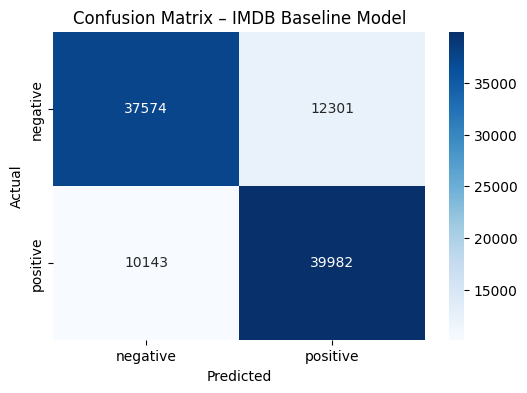

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=model.classes_,
            yticklabels=model.classes_,
            cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – IMDB Baseline Model")
plt.show()